In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
import random
import os


In [56]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import pandas as pd

# Set Random Seed for Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Parse the dataset
def parse_dataset(file_path):
    labels = []
    sequences = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                label = re.search(r'\((.*?)\)', line).group(1)
                labels.append(label)
            else:
                sequences.append(line.strip())
    return labels, sequences

labels, sequences = parse_dataset('25PDB dataset.TXT')

# Filter the dataset to include only 'alpha class' and 'beta class'
desired_classes = ['alpha class', 'beta class']
filtered_labels = []
filtered_sequences = []
for label, seq in zip(labels, sequences):
    if label in desired_classes:
        filtered_labels.append(label)
        filtered_sequences.append(seq)

# One-Hot编码并填充序列
def one_hot_encode(sequences, max_length=None):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_dict = {aa: idx for idx, aa in enumerate(amino_acids)}
    encoded = []
    for seq in sequences:
        encoded_seq = [aa_dict.get(aa, -1) for aa in seq]
        encoded.append(encoded_seq)
    
    if not max_length:
        max_length = max(len(seq) for seq in encoded)
    
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=-1)
    
    num_classes = len(amino_acids)
    X = np.zeros((padded.shape[0], padded.shape[1], num_classes))
    for i, seq in enumerate(padded):
        for j, aa in enumerate(seq):
            if aa != -1:
                X[i, j, aa] = 1
    return X, max_length

X, max_len = one_hot_encode(filtered_sequences)

# Prepare Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_labels)
y = to_categorical(y)

# Split Data into Train, Validation, and Test sets
# First, split into training and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the temporary set into validation and test sets (50% of 20% = 10% for validation, 10% for test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 创建子文件夹
data_folder = './data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)  # 如果子文件夹不存在，则创建它

# # Save data to the current folder
# output_folder = "./"

# Save the NumPy array
np.save(os.path.join(data_folder, "X_train.npy"), X_train)
np.save(os.path.join(data_folder, "X_valid.npy"), X_valid)
np.save(os.path.join(data_folder, "X_test.npy"), X_test)
np.save(os.path.join(data_folder, "y_train.npy"), y_train)
np.save(os.path.join(data_folder, "y_valid.npy"), y_valid)
np.save(os.path.join(data_folder, "y_test.npy"), y_test)

# Save labels and statistics
labels_series = pd.Series(filtered_labels)
labels_series.to_csv(os.path.join(data_folder, "filtered_labels.csv"), index=False)
labels_series.value_counts().to_csv(os.path.join(data_folder, "label_counts.csv"))

# Print basic information about the data
print("X_train, X_valid, X_test, y_train, y_valid, y_test have been saved to the current folder!")
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)


X_train, X_valid, X_test, y_train, y_valid, y_test have been saved to the current folder!
(708, 571, 20) (89, 571, 20) (89, 571, 20) (708, 2) (89, 2) (89, 2)


In [57]:
X_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [59]:
import pandas as pd

labels_series = pd.Series(filtered_labels)
labels_series.value_counts()

alpha class    443
beta class     443
Name: count, dtype: int64

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) detected and memory growth set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Using CPU.")


1 GPU(s) detected and memory growth set.


In [61]:
# CNN

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# 构建模型
input_layer = Input(shape=(max_len, X_train.shape[2]))

# 第一卷积层
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)

# 第二卷积层
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)
conv2 = MaxPooling1D(pool_size=2)(conv2)

# 第三卷积层
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)
conv3 = MaxPooling1D(pool_size=2)(conv3)

# 展平层
flatten_layer = Flatten()(conv3)

# 全连接层
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(flatten_layer)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.5)(dense1)

# 输出层
output_layer = Dense(y_train.shape[1], activation='softmax')(dense1)

# 构建模型
cnn_model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=0.0006)
cnn_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# 模型结构总结
cnn_model.summary()

# 添加EarlyStopping和ReduceLROnPlateau回调函数
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# 训练模型
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 571, 20)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 571, 64)           3904      
                                                                 
 batch_normalization_8 (Batc  (None, 571, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 571, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 285, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 285, 128)          2470

In [62]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

# 模型评估
# 在验证集上评估模型性能。
loss, accuracy, precision, recall = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Validation set - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Validation set - Loss: 0.7966, Accuracy: 0.4607, Precision: 0.4607, Recall: 0.4607


In [63]:

# CNN-Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# 构建优化后的模型
input_layer = Input(shape=(max_len, X_train.shape[2]))

# 第一卷积层
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)

# 第二卷积层
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)
conv2 = MaxPooling1D(pool_size=2)(conv2)

# 第三卷积层
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)
conv3 = MaxPooling1D(pool_size=2)(conv3)

# 展平层
flatten_layer = Flatten()(conv3)

# Attention层
attention = Attention()([flatten_layer,flatten_layer])
attention = Flatten()(attention)

# 全连接层
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(attention)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.5)(dense1)

# 输出层
output_layer = Dense(y_train.shape[1], activation='softmax')(dense1)

# 构建模型
cnn_attention_model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=0.0006)
cnn_attention_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_attention_model.summary()

# 添加EarlyStopping和ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# 训练模型
cnn_attention_history = cnn_attention_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 571, 20)]    0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 571, 64)      3904        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 571, 64)     256         ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_13 (Dropout)           (None, 571, 64)      0           ['batch_normalization_12[0]

In [64]:

# LSTM

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# LSTM
# 构建优化后的模型
input_layer = Input(shape=(max_len, X_train.shape[2]))


# 双向LSTM层，返回序列
bi_lstm = Bidirectional(LSTM(256,  kernel_regularizer=l2(1e-4)))(input_layer)
# bi_lstm = BatchNormalization()(bi_lstm)
bi_lstm = Dropout(0.3)(bi_lstm)

# # Attention层
# attention = Attention()([bi_lstm, bi_lstm])
# flatten = tf.keras.layers.Flatten()(attention)

# 输出层
output_layer = Dense(y_train.shape[1], activation='softmax')(bi_lstm)

# 构建模型
lstm_model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=0.0006)
lstm_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

lstm_model.summary()

# 添加EarlyStopping和ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# 训练模型
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 571, 20)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              567296    
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 568,322
Trainable params: 568,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 14s 369ms/step - loss: 0.6924 - accuracy: 0.5932 - precision_5: 0.

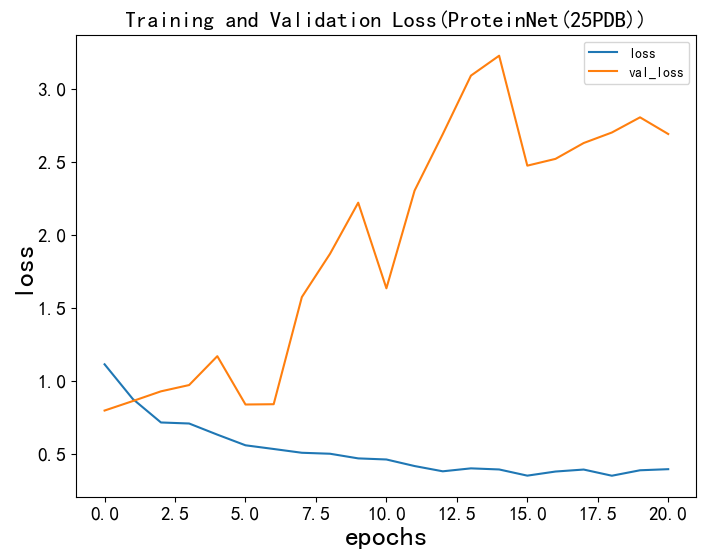

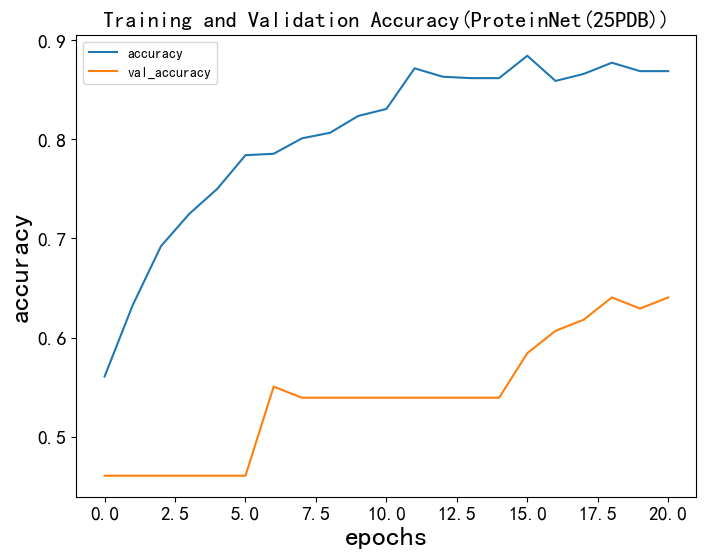

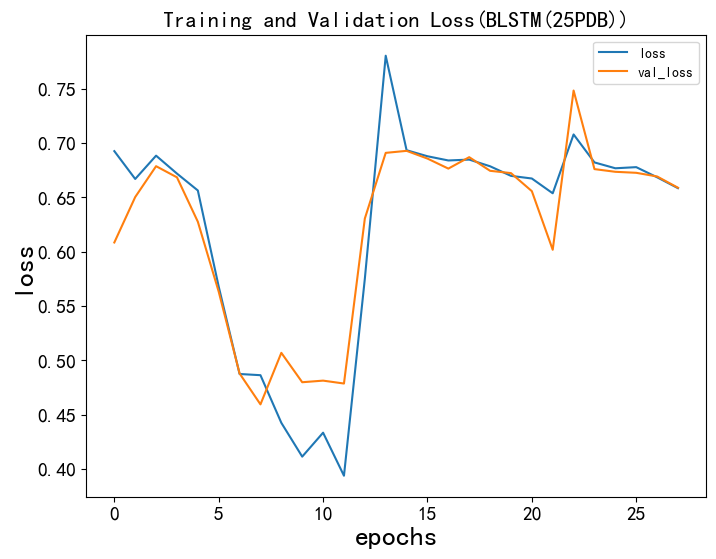

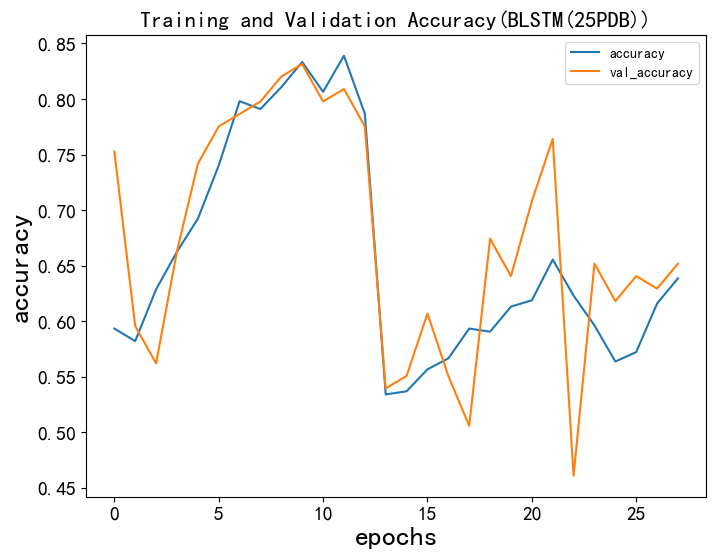

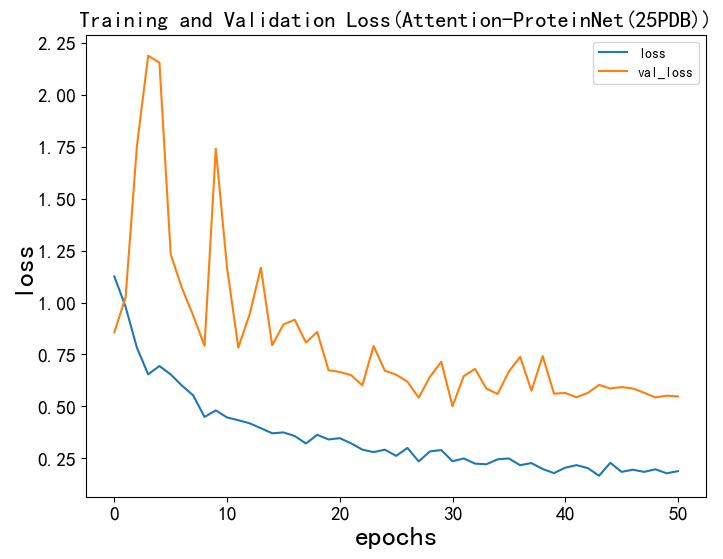

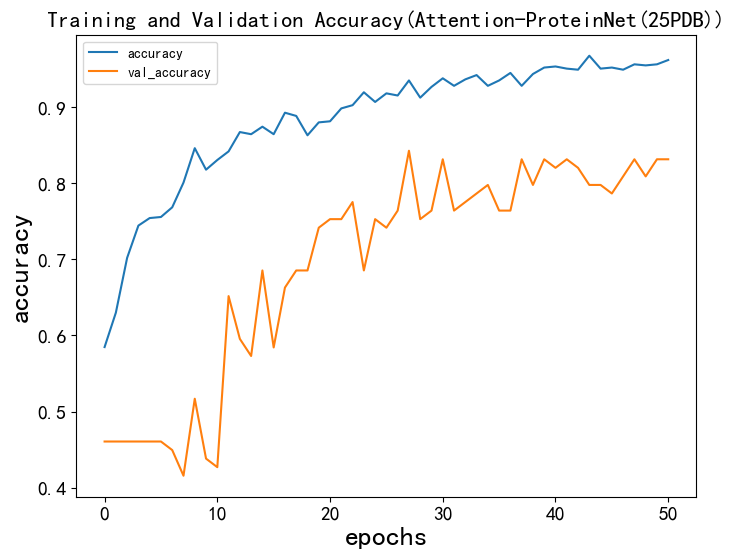

In [65]:
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建文件夹
output_folder = 'Fianl Result Plots(25PDB)'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)  # 如果文件夹不存在，则创建它


# CNN_Model
# 损失函数
plt.figure(figsize=(8, 6))
plt.plot(cnn_history.history['loss'], label='loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss(ProteinNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('loss', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'loss_curve(ProteinNet(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# 准确率
plt.figure(figsize=(8, 6))
plt.plot(cnn_history.history['accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy(ProteinNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('accuracy', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'accuracy_curve(ProteinNet(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# LSTM
plt.figure(figsize=(8, 6))

# 损失函数
plt.plot(lstm_history.history['loss'], label='loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss(BLSTM(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('loss', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'loss_curve(BLSTM(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# 准确率
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['accuracy'], label='accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy(BLSTM(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('accuracy', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'accuracy_curve(BLSTM(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# CNN_Attention
# 损失函数
plt.figure(figsize=(8, 6))
plt.plot(cnn_attention_history.history['loss'], label='loss')
plt.plot(cnn_attention_history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss(Attention-ProteinNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('loss', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'loss_curve(Attention-ProteinNet(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# 准确率
plt.figure(figsize=(8, 6))
plt.plot(cnn_attention_history.history['accuracy'], label='accuracy')
plt.plot(cnn_attention_history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy(Attention-ProteinNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('accuracy', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(output_folder, 'accuracy_curve(Attention-ProteinNet(25PDB)).png'), dpi=600)

plt.show()


In [69]:
import os
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# 定义输出文件夹路径
output_folder = "./Compared Final Result Plots(25PDB)"
os.makedirs(output_folder, exist_ok=True)

# 模型预测结果（假设四种模型已定义并训练完成）
models = {
    "ProteinNet": cnn_model,
    "Attention-ProteinNet": cnn_attention_model,
    "BLSTM": lstm_model,
    # "Attention-ProteinMeNet": model
}

# 真实标签 (one-hot 编码)
y_true = np.argmax(y_test, axis=1)  # 转换为整数标签
n_classes = y_test.shape[1]  # 类别数

for model_name, model_instance in models.items():
    print(f"Evaluating {model_name}...")

    # 获取模型预测
    y_pred_proba = model_instance.predict(X_test)  # 预测概率
    y_pred = np.argmax(y_pred_proba, axis=1)  # 获取预测类别

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_,
        annot_kws={"size": 18}  # 设置注释数字的字体大小
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=20, weight='bold')  # 加粗标题
    plt.ylabel('True Label', fontsize=20, weight='bold')  # 加粗y轴标签
    plt.xlabel('Predicted Label', fontsize=20, weight='bold')  # 加粗x轴标签
    # 设置坐标轴刻度标签的字体大小
    plt.tick_params(axis='both', which='major', labelsize=16)

    # 自动调整布局，避免标签和注释重叠
    plt.tight_layout()

    # 保存混淆矩阵图像（600 DPI）
    conf_matrix_path = os.path.join(output_folder, f"{model_name}_confusion_matrix(25PDB).png")
    plt.savefig(conf_matrix_path, dpi=600)
    plt.close()

    print(f"Confusion matrix saved to {conf_matrix_path}")


    # 输出评估指标
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # 输出分类报告
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print(f"Classification Report for {model_name}:\n{report}")

    # 绘制 ROC 曲线
    plt.figure(figsize=(10, 8))
    if n_classes == 2:  # 二分类情况
        fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
        auc = roc_auc_score(y_test[:, 1], y_pred_proba[:, 1])
        plt.plot(fpr, tpr, color='orange', label=f"ROC curve (AUC = {auc:.2f})")
    else:  # 多分类情况
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, color='orange', label=f"Class {label_encoder.classes_[i]} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # 随机猜测参考线
    plt.title(f'ROC Curve - {model_name}', fontsize=20, weight='bold')  # 加粗标题
    plt.xlabel('False Positive Rate', fontsize=20, weight='bold')  # 加粗x轴标签
    plt.ylabel('True Positive Rate', fontsize=20, weight='bold')  # 加粗y轴标签
    plt.legend(loc='lower right')
    # 设置坐标轴数字的字体大小
    plt.tick_params(axis='both', which='major', labelsize=14) 
    
    # 保存 ROC 曲线图像（600 DPI）
    roc_curve_path = os.path.join(output_folder, f"{model_name}_roc_curve(25PDB).png")
    plt.savefig(roc_curve_path, dpi=600)
    plt.close()

    # 绘制 Precision-Recall 曲线
    plt.figure(figsize=(10, 8))
    if n_classes == 2:  # 二分类情况
        precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred_proba[:, 1])
        plt.plot(recall, precision, label="Precision-Recall Curve")
    else:  # 多分类情况
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
            plt.plot(recall, precision, label=f"Class {label_encoder.classes_[i]}")

    plt.title(f'Precision-Recall Curve - {model_name}', fontsize=20, weight='bold')  # 加粗标题
    plt.xlabel('Recall', fontsize=20, weight='bold')  # 加粗x轴标签
    plt.ylabel('Precision', fontsize=20, weight='bold')  # 加粗y轴标签
    plt.legend(loc='upper right')
     
    # 设置坐标轴数字的字体大小
    plt.tick_params(axis='both', which='major', labelsize=14) 

    # 保存 Precision-Recall 曲线图像（600 DPI）
    pr_curve_path = os.path.join(output_folder, f"{model_name}_precision_recall_curve(25PDB).png")
    plt.savefig(pr_curve_path, dpi=600)
    plt.close()

print(f"All results saved in {output_folder}")


Evaluating ProteinNet...
3/3 [==============================] - 0s 12ms/step
Confusion matrix saved to ./Compared Final Result Plots(25PDB)\ProteinNet_confusion_matrix(25PDB).png
ProteinNet - Precision: 0.2122, Recall: 0.4607, F1 Score: 0.2906
Classification Report for ProteinNet:
              precision    recall  f1-score   support

 alpha class       0.00      0.00      0.00        48
  beta class       0.46      1.00      0.63        41

    accuracy                           0.46        89
   macro avg       0.23      0.50      0.32        89
weighted avg       0.21      0.46      0.29        89

Evaluating Attention-ProteinNet...
3/3 [==============================] - 0s 12ms/step
Confusion matrix saved to ./Compared Final Result Plots(25PDB)\Attention-ProteinNet_confusion_matrix(25PDB).png
Attention-ProteinNet - Precision: 0.8313, Recall: 0.8315, F1 Score: 0.8313
Classification Report for Attention-ProteinNet:
              precision    recall  f1-score   support

 alpha class  

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 创建保存结果的文件夹
output_folder = "./ Compared Final Result Plots(25PDB)"
os.makedirs(output_folder, exist_ok=True)

# 假设四个模型的预测概率和真实标签
# y_pred_proba_*：各个模型对测试集的预测概率
y_pred_proba_1 = cnn_model.predict(X_test)
y_pred_proba_2 = cnn_attention_model.predict(X_test)
y_pred_proba_3 = lstm_model.predict(X_test)
y_pred_proba_4 = model.predict(X_test)

# 真实标签 (one-hot编码形式)
y_true = y_test  # 确保 y_test 是 one-hot 编码

# 转换真实标签为二分类格式
y_true_binary = y_true[:, 1]  # 取第二列表示正类

# 初始化 ROC 曲线图
plt.figure(figsize=(10, 8))

# 绘制CNN 的 ROC 曲线
fpr1, tpr1, _ = roc_curve(y_true_binary, y_pred_proba_1[:, 1])
auc1 = roc_auc_score(y_true_binary, y_pred_proba_1[:, 1])
plt.plot(fpr1, tpr1, label=f'ProteinNet(25PDB)(AUC = {auc1:.2f})')

# 绘制CNN_Attention的 ROC 曲线
fpr2, tpr2, _ = roc_curve(y_true_binary, y_pred_proba_2[:, 1])
auc2 = roc_auc_score(y_true_binary, y_pred_proba_2[:, 1])
plt.plot(fpr2, tpr2, label=f'Attention-ProteinNet(25PDB)(AUC = {auc2:.2f})')

# 绘制LSTM 的 ROC 曲线
fpr3, tpr3, _ = roc_curve(y_true_binary, y_pred_proba_3[:, 1])
auc3 = roc_auc_score(y_true_binary, y_pred_proba_3[:, 1])
plt.plot(fpr3, tpr3, label=f'BLSTM(25PDB)(AUC = {auc3:.2f})')

# 绘制Hybrid Model 的 ROC 曲线
fpr4, tpr4, _ = roc_curve(y_true_binary, y_pred_proba_4[:, 1])
auc4 = roc_auc_score(y_true_binary, y_pred_proba_4[:, 1])
plt.plot(fpr4, tpr4, label=f'Attention-ProteinMeNet(25PDB)(AUC = {auc4:.2f})')

# 添加参考线和图例
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # 随机猜测的参考线

# 设置标题和轴标签并加粗
plt.xlabel('False Positive Rate (FPR)', fontsize=20, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=20, fontweight='bold')
plt.title('ROC Curves for Four Models(25PDB)', fontsize=20, fontweight='bold')

# 图例
plt.legend(loc='lower right', fontsize=16)
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 
plt.grid()

# 保存 ROC 曲线图像，分辨率设置为600 DPI
roc_curve_filename = os.path.join(output_folder, "roc_curves(25PDB).png")
plt.savefig(roc_curve_filename, dpi=600)

# 显示图像
plt.show()

# 关闭图像，防止影响后续图像
plt.close()

print(f"ROC curves saved to {roc_curve_filename}")
